<a href="https://www.kaggle.com/code/duynhatvo/clashroyale?scriptVersionId=93721569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Clash Royale Dataset Analysis

### TODO

1) Average Elixir (Classification)
- compute average elixir for each deck and try to figure out if there is a specific range which is better than others

2) Troop types
- air/ground/spell/building

3) Rarity
- common/rare/legend/champion

## 1. Introduction

In this notebook, we are going to analyze the [Clash Royale Dataset](https://www.kaggle.com/datasets/nonrice/clash-royale-battles-upper-ladder-december-2021). This dataset documents over 700 thousands matches of the mobile game [Clash Royale](https://clashroyale.com/) by Supercell. We will first brief through the basic mechanics of the games and the goal of this project, then the analysis and conclusion part.

## 2. Objectives:
### a. Clash Royale:
Clash Royale is a realtime strategy mobile game, where 2 players fight over a 3-minute match to destroy their opponent's towers. Each player will have a prechosen deck consisting of 8 cards, and will continuously deploy their cards which are either minions or spells. The game ends after 3 minutes, or if a player's main tower is destroyed.

As simple as it may sound, analyzing who would win a match is very difficult, due to the huge permutations of cards (there are 106 cards in total), as well as the different players' skills. In this notebook, we are going to analyze the dataset with the following assumptions:
- The matches happen in a small time span (December 2021), and no update (tweaks to each card's stats) are done.
- The matches happen between the top-ranked players in the world, and they all have very similar skills.

### b. Our approach:
In this notebook, we are going to try and see whether we can predict an outcome of a match using the decks and the rank of each player.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
import json
import csv

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [56]:
# bulshitting

# file = open('data/cards.csv', 'r')
# cards_stats = csv.reader(file)

# for row in cards_stats:
#     print(row)
#     if row[4] == 'troop':
#         if row[7] > 0:
#             row[4] = 'Air_Troop'
#         else:
#             row[4] = 'Ground_Troop'

# cards_stats[4].unique()
# print(cards_stats)
# for i in cards_stats['troop']:
#     if i['key'] == 'barbarian-barrel':
#         print(i)

In [34]:
battles = pd.read_csv('data/battles.csv')
print(battles[['p1_tag', 'p1_trophy', 'p2_tag', 'p2_trophy',
               'p1_crowns', 'p2_crowns', 'winner']][:5])
print("")
print("Total number of Columns:", len(list(battles.columns)))
print("Total number of Rows:", len(list(battles.index)))
print("")
print("Column Names:", list(battles.columns))

      p1_tag  p1_trophy      p2_tag  p2_trophy  p1_crowns  p2_crowns  winner
0  #LYCGVUPY       7273    #JVY90UY       7306          2          0       1
1  #LYCGVUPY       7242  #LR8R9VL0U       7265          1          0       1
2  #LYCGVUPY       7269  #2CLRUVVPQ       7303          0          1       2
3  #LYCGVUPY       7236  #Y2CPJL92C       7271          2          1       1
4  #LYCGVUPY       7208  #L00RCJYG2       7187          2          1       1

Total number of Columns: 40
Total number of Rows: 1426

Column Names: ['Unnamed: 0', 'p1_tag', 'p1_trophy', 'p1_card_0_id', 'p1_card_0_lv', 'p1_card_1_id', 'p1_card_1_lv', 'p1_card_2_id', 'p1_card_2_lv', 'p1_card_3_id', 'p1_card_3_lv', 'p1_card_4_id', 'p1_card_4_lv', 'p1_card_5_id', 'p1_card_5_lv', 'p1_card_6_id', 'p1_card_6_lv', 'p1_card_7_id', 'p1_card_7_lv', 'p1_crowns', 'p2_tag', 'p2_trophy', 'p2_card_0_id', 'p2_card_0_lv', 'p2_card_1_id', 'p2_card_1_lv', 'p2_card_2_id', 'p2_card_2_lv', 'p2_card_3_id', 'p2_card_3_lv', 'p2_card_

As can be seen above, we have collected 1426 unique vectors of datapoints with 40 columns each that provide us with relevant information on their respective battle. 19 columns are divided each between the two players where 16 columns are for the cards with 8 each for the unique card ID and its corresponding level and out of the 3 remaining columns, 1 each for ID, trophies, and crowns. Essentially, the column names represent:
- $p\_tag$: Unique ID of the player
- $p\_trophy$: The trophies of the player (can be thought of as ranking)
- $p\_crowns$: The number of towers destroyed of by the player in the battle (max 3 == win)
- $p\_card\_x\_id$: The unique card ID of card $x$
- $p\_card\_x\_level$: The level of the corresponding card $x$
- $p\_winner$: The player who won the game

The unique card ID's have specific data points as described in the cell below where cards data is analyzed.


In [36]:
cards = pd.read_csv('data/cards.csv')
print(cards[['key', 'elixir', 'type', 'rarity']][:5])
print("")
print("Number of Columns:", len(list(cards.columns)))
print("Number of Rows:", len(list(cards.index)))
print("")
print("Column Names:", list(cards.columns))
print("")
print("Types of cards:", sorted(cards['type'].unique()))
print("Rarity of cards:", sorted(cards['rarity'].unique()))
print("Elixir for cards:", sorted(cards['elixir'].unique()))

       key  elixir   type  rarity
0   knight       3  Troop  Common
1  archers       3  Troop  Common
2  goblins       2  Troop  Common
3    giant       5  Troop    Rare
4    pekka       7  Troop    Epic

Number of Columns: 11
Number of Rows: 107

Column Names: ['key', 'name', 'sc_key', 'elixir', 'type', 'rarity', 'id', 'flying_height', 'range', 'damage_air', 'damage_ground']

Types of cards: ['Building', 'Spell', 'Troop']
Rarity of cards: ['Champion', 'Common', 'Epic', 'Legendary', 'Rare']
Elixir for cards: [1, 2, 3, 4, 5, 6, 7, 8, 9]


There are three ... 

## 3. Preliminary Analysis:
### a. A brief overview:
We are first going to have a quick look to get a sense of the data. First, we will have a look at the dataset, and its correlation matrix to understand any relations in the datapoints.

In [38]:
battles.drop(columns='Unnamed: 0', inplace=True)

In [39]:
SIZE = 1426
df = battles.sample(1000, random_state=84)

In [40]:
df.describe()

,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,p1_card_4_id,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
count,1000.00000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,...,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,6477.15200,2.638903e+07,9.739000,2.648103e+07,9.315000,2.687602e+07,10.133000,2.671503e+07,10.606000,2.659102e+07,...,2.659503e+07,9.997000,2.667802e+07,9.962000,2.677102e+07,10.342000,2.695402e+07,10.049000,0.733000,1.415000
std,449.89271,7.390595e+05,3.202364,7.862820e+05,3.220582,9.494726e+05,3.133549,9.211920e+05,3.283526,8.697441e+05,...,8.681625e+05,3.246464,8.983875e+05,3.211677,9.409669e+05,3.175077,9.678821e+05,3.287462,0.880049,0.494995
min,1443.00000,2.600000e+07,2.000000,2.600000e+07,2.000000,2.600000e+07,1.000000,2.600001e+07,2.000000,2.600000e+07,...,2.600000e+07,2.000000,2.600000e+07,1.000000,2.600000e+07,2.000000,2.600000e+07,2.000000,0.000000,0.000000
25%,6390.00000,2.600002e+07,6.000000,2.600002e+07,6.000000,2.600004e+07,9.000000,2.600003e+07,9.000000,2.600002e+07,...,2.600003e+07,6.000000,2.600003e+07,6.000000,2.600003e+07,9.000000,2.600003e+07,6.000000,0.000000,1.000000
50%,6467.00000,2.600004e+07,9.000000,2.600004e+07,9.000000,2.600008e+07,12.000000,2.600007e+07,12.000000,2.600005e+07,...,2.600005e+07,9.000000,2.600005e+07,9.000000,2.600006e+07,12.000000,2.700000e+07,9.000000,1.000000,1.000000
75%,6592.25000,2.600008e+07,12.000000,2.700001e+07,12.000000,2.800000e+07,12.000000,2.800000e+07,14.000000,2.800000e+07,...,2.800000e+07,12.000000,2.800000e+07,12.000000,2.800000e+07,14.000000,2.800001e+07,14.000000,1.000000,2.000000
max,7273.00000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,...,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,3.000000,2.000000


In [41]:
corr = df.corr()

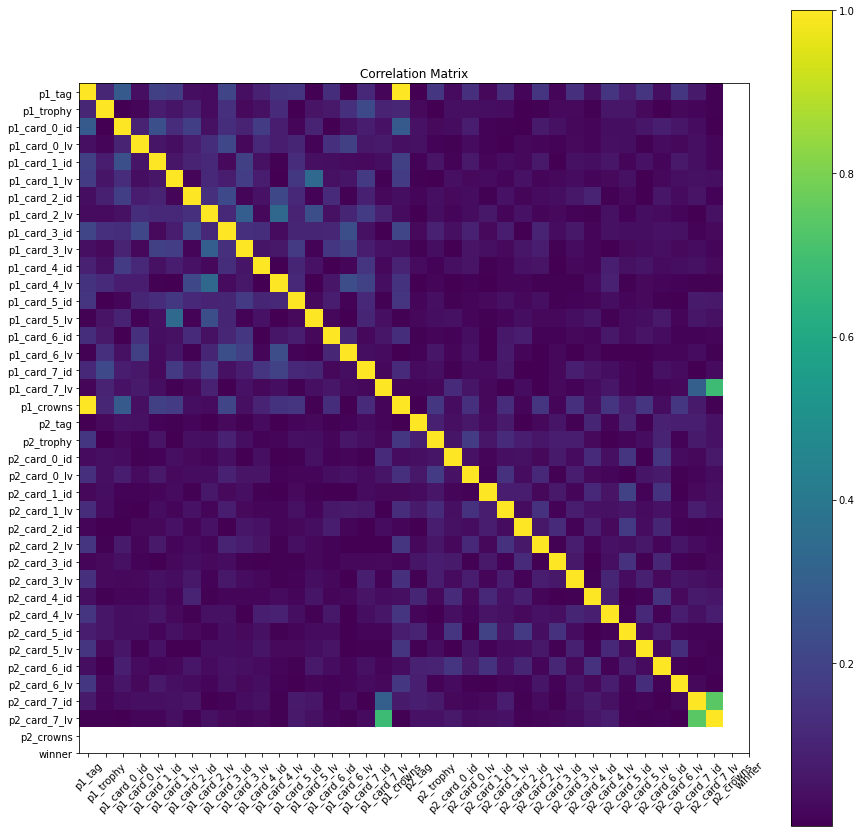

In [42]:
f = plt.figure(figsize=(15, 15))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

Lets drop some columns that do not seem to be correlated to get a better picture.

In [47]:
less_cols = df
cols_to_drop = []
for col_name in df.columns:
    if 'lv' in col_name or 'tag' in col_name:
        cols_to_drop.append(col_name)
# remove cols with levels
less_cols.drop(columns=cols_to_drop, inplace=True)
corr = less_cols.corr()

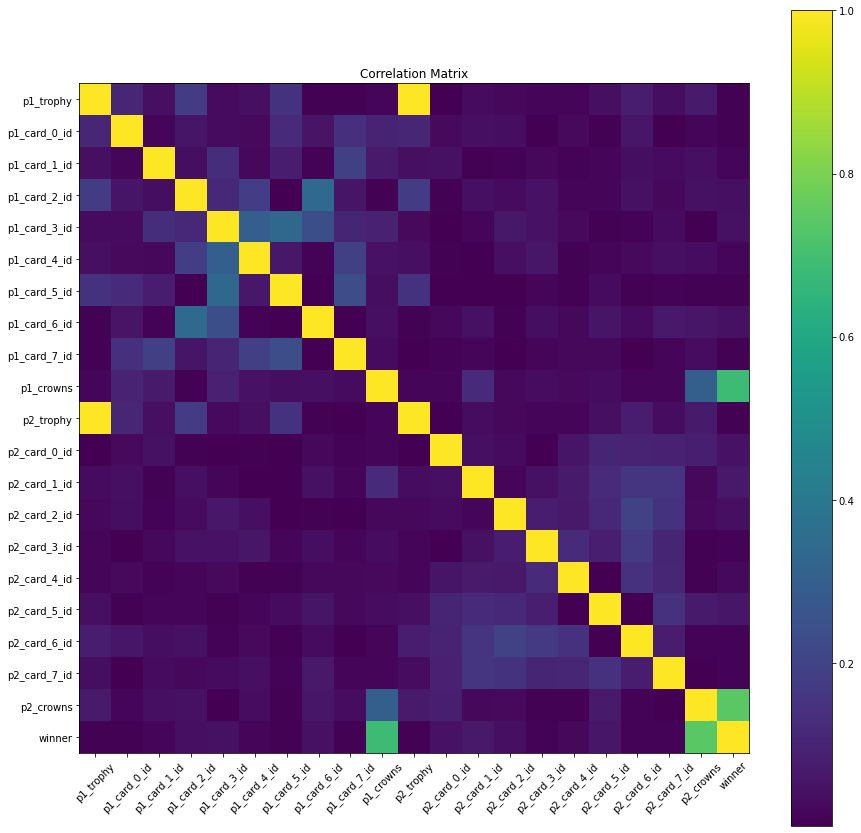

In [48]:
f = plt.figure(figsize=(15, 15))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.xticks(np.arange(df.shape[1]), df.columns, rotation=45)
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

#### Remarks:
From the plotted correlation matrix, we observe that there seems to be a clear relationship between:
- The current card and the next card(s) in each player's deck
- The players' rankings (trophies) with each other
- Players' rankings (trophies) and cards in their deck

The first relation is very intuitive. This is because cards often have synergies (i.e some go well with others as support fillers while other do not). In this case, the results can be interpreted to explain that every card is followed by another specific card to complement the first one to build a strategy (catch: this is a strategy game). There are also relationships with further cards in the deck and even though they get weaker it is straightforward to realize that the cards are played out in a specific manner to build a strategy.  

Furthermore, the players' rankings should be correlated as well which is well supported by the graph. This is so because the game's "match-making process" is based on player rankings, (and players of different rankings seems to use similar decks of cards.) --- how?

However, unfortunately, it is evident that there is almost no correlation between the outcome and any other attributes of the dataset from this analysis. We can try to apply some well-known classifications methods and check if they give us promising results.

### b. Basic Algorithms:
In the following cells we do the following:
1. We first encode each players' deck into $1 \times 106$ vectors, where $V_i = 1$ if the $i^{th}$ card is in the deck, $0$ otherwise. This seems to be a better choice than one-hot encoding, as there are $\begin{pmatrix}106 \\ 8 \end{pmatrix} \approx 3 \times 10^{11}$ possible choices of decks.
2. We then split the whole data set into training sets and test sets for supervised classification. We also keep a list of all decks choice people used to see if unsupervised learning give us some better insights into the data set.
3. We then apply some well-known simple Classification methods (e.g KNN, Decsion Trees, etc.) to see if we get a good result.

In [53]:
from sklearn.model_selection import train_test_split
y_train = df['winner']
x_train, decks = [], []

# we first combine the DataFrame into 1x106 vectors, where V[i] = 1 if the ith card is in the deck
# this 
for i in range(df.shape[0]):
    p1 = np.zeros(106)
    p2 = np.zeros(106)
    for j in range(1, 9):
        p1[df[f'p1_card_{j}_id'][i]] = 1
        p2[df[f'p2_card_{j}_id'][i]] = 1
    decks.append(p1)
    decks.append(p2)
    x_train.append(np.concatenate((p1, p2)))
    
x_train = np.array(x_train)
decks = np.array(decks)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=6233)
d_train, d_test = train_test_split(decks, test_size=0.2, random_state=47483)

IndexError: index 26000042 is out of bounds for axis 0 with size 106

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [74]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print('Training accuracy:\t', knn.score(x_train, y_train))
print('Testing accuracy:\t', knn.score(x_test, y_test))

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20))
# ada.fit(x_train, y_train)
# print('Training accuracy:\t', ada.score(x_train, y_train))
# print('Testing accuracy:\t', ada.score(x_test, y_test))

In [ ]:
bagging = BaggingClassifier(DecisionTreeClassifier(max_depth=20))
bagging.fit(x_train, y_train)
print('Training accuracy:\t', bagging.score(x_train, y_train))
print('Testing accuracy:\t', bagging.score(x_test, y_test))

In [ ]:
extra = ExtraTreesClassifier(max_depth=20)
extra.fit(x_train, y_train)
print('Training accuracy:\t', extra.score(x_train, y_train))
print('Testing accuracy:\t', extra.score(x_test, y_test))

In [ ]:
rf = RandomForestClassifier(max_depth=20)
rf.fit(x_train, y_train)
print('Training accuracy:\t', rf.score(x_train, y_train))
print('Testing accuracy:\t', rf.score(x_test, y_test))

#### Remarks:
Unfortunately, our models does not seem to have a good predictions overall (the score is only a bit better than random guessing). In the following parts of the notebook, we are going to see if we could obtain a better fit on this dataset.

## 4. Decks Analysis:
Let us dig deeper into the dataset by analyzing the decks, which seems to be most correlated.

We first visualize the correlation matrix (now with the new encoding).

In [54]:
d_corr = np.corrcoef(decks.T)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

AttributeError: 'list' object has no attribute 'T'

#### Remarks:
We want to observe which pairs have the highest synergy. The following cells sets all correlation under the diagonal to 0, and sort them by value.

In [ ]:
d_corr_u = np.triu(d_corr, k=1)
d_corr_u
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(d_corr_u))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [ ]:
d_corr_flat = d_corr_u.flatten()
d_corr_argsort = np.argsort(d_corr_flat)
d_corr_high = [(x // 106, x % 106, d_corr_flat[x]) for x in d_corr_argsort[:-31:-1]]
d_corr_low = [(x // 106, x % 106, d_corr_flat[x]) for x in d_corr_argsort[:30]]

In [ ]:
[(card_names[x], card_names[y], z) for (x, y, z) in d_corr_high]

In [ ]:
[(card_names[x], card_names[y], z) for (x, y, z) in d_corr_low]

#### Remarks:
We observe that these card pairs are very common in the strongest decks (from https://www.deckshop.pro/).

## 5. A deeper look at Outcome:
### a. Applying PCA:

In [ ]:
data = np.copy(x_train).T.tolist()
data.append(y_train)
data = np.array(data)

In [ ]:
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train)

In [ ]:
data = np.copy(x_train_pca).T.tolist()
data.append(y_train)
data = np.array(data)
corr = np.corrcoef(data)
f = plt.figure(figsize=(16, 12))
plt.imshow(np.abs(corr))
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), x_train_pca[:, 2].flatten(), c = y_train.tolist())

In [ ]:
plt.scatter(x_train_pca[:,0].flatten(), x_train_pca[:, 1].flatten(), c = y_train.tolist())

In [ ]:
# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15))
# ada.fit(x_train_pca, y_train)
# print('Training accuracy:\t', ada.score(x_train_pca, y_train))
# print('Testing accuracy:\t', ada.score(pca.transform(x_test), y_test))

In [ ]:
extra = ExtraTreesClassifier(max_depth=15)
extra.fit(x_train_pca, y_train)
print('Training accuracy:\t', extra.score(x_train_pca, y_train))
print('Testing accuracy:\t', extra.score(pca.transform(x_test), y_test))

### b. How about Neural Network?
Let's try to see if we can instead obtain a good score using Neural Network. 

We first try a naive Neural Network, with all layers are dense, and two Dropouts.

In [ ]:
from tensorflow import keras
nn = keras.Sequential([
    keras.layers.Dense(128, activation='ReLU'),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='ReLU'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='ReLU'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
nn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
nn.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=16, callbacks=[early_stopping])

In [ ]:
nn.evaluate(x_test, y_test)

#### Remarks: 
The previous one did not really give a very good score, so let's try to see if we could use a different network structure.

Through the previous analysis on Decks, we observe that a deck is characterized by a small number of cards. With that in mind, it makes sense to use CNN on this model, as in the following cell.

In [ ]:
from tensorflow import keras
cnn = keras.Sequential([
    keras.layers.Dense(212, activation='relu'),
    keras.layers.Conv1D(32, 4, padding='same', activation='relu'),
    keras.layers.Conv1D(32, 4, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool1D(8),
    keras.layers.Conv1D(64, 4, activation='relu'),
    keras.layers.Conv1D(64, 4, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool1D(8),
    keras.layers.Dense(128, activation='ReLU'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
cnn.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy'],
)
cnn.fit(x_train.reshape((x_train.shape[0], x_train.shape[1], 1)), y_train, validation_split=0.1, epochs=30, batch_size=16, callbacks=[early_stopping])

In [ ]:
cnn.evaluate(x_test.reshape((x_test.shape[0], x_test.shape[1], 1)), y_test)

#### Remarks:
The result indeed looks much better than our naive model. We observe that indeed, it is better to look at a match in terms of the main cards used in each battle.

However, it appears that, unfortunately, we cannot really get a much better prediction of outcome than decision trees.

Still, with our previous analysis, it seems that we could try and get a good result at deck building.

## 6. Deck Building:

In [ ]:
synergies = np.array([(i, j, d_corr[i][j]) for i in range(N_CARDS) for j in range(i+1, N_CARDS)])

In [ ]:
import seaborn as sns
x_train, y_train = synergies[:, :2], synergies[:, 2]
fig = plt.figure(figsize=(12, 8))
sns.distplot(y_train)

## 7. Elixir Analysis:

## 8. Troop Type Analysis

Now, we will try to analyze the decks based on the types of cards. In the original data, we have 3 types of cards: 
- $Troop$
- $Spell$ 
- $Building$ 

But, we will divide the $Troop$ type into:
- $Air\_Troop$ 
- $Ground\_Troop$

The difference between these two is that $Air\_Troop$ have $flying\_height>0$ and as the name suggests, they are positioned above 0 on the z-axis in the game. The number of $Air\_Troops$ may/may not have an effect on the result of the match and that is why we will try to train our models and see if our predictions are any better with these troop types. We modify the data accordingly in the cell below. 

In [50]:
cards = pd.read_csv('data/cards.csv')
print(cards)

print("Unique cards before modification:", cards['type'].unique().tolist())

for row_index in cards.index:
#     print(cards.loc[row_index])
    if cards.loc[row_index, 'type'] == 'Troop':
        if cards.loc[row_index, 'flying_height'] > 0:
            cards.loc[row_index, 'type'] = 'Air_Troop'
        else:
            cards.loc[row_index, 'type'] = 'Ground_Troop'

print("Unique cards after modification:", cards['type'].unique().tolist())

                  key              name         sc_key  elixir   type  rarity  \
0              knight            Knight         Knight       3  Troop  Common   
1             archers           Archers         Archer       3  Troop  Common   
2             goblins           Goblins        Goblins       2  Troop  Common   
3               giant             Giant          Giant       5  Troop    Rare   
4               pekka         P.E.K.K.A          Pekka       7  Troop    Epic   
..                ...               ...            ...     ...    ...     ...   
102        earthquake        Earthquake     Earthquake       3  Spell    Rare   
103  barbarian-barrel  Barbarian Barrel        BarbLog       2  Spell    Epic   
104       heal-spirit       Heal Spirit           Heal       1  Troop    Rare   
105    giant-snowball    Giant Snowball       Snowball       2  Spell  Common   
106    royal-delivery    Royal Delivery  RoyalDelivery       3  Spell  Common   

           id  flying_heigh

## 9. Troop Rarity Analysis